### <a href='https://docs.google.com/document/d/1goy1LCq5ocgsfNSvJXpvD-cKS7caWAtBM7IWWMsWo0Y/edit'>  Тестовое задание </a>  на должность <a href='https://spb.hh.ru/vacancy/40591949'> Аналитик данных (junior).</a>
### Выполнил <a href='https://spb.hh.ru/resume/e52cd67aff085c49c70039ed1f664f4e637151'> Вадим Мазейко.</a>

### Задание 1. Сам себе Шпилькин.

13 сентября в Краснодаре прошли выборы в городскую думу.

- Выведите в консоль номера УИК, в составе которых не было представителя КПРФ и номер их округа. 
Формат выхода - номера УИК через запятую

- Выведите в консоль на сколько отличается средний результат КПРФ на участках, где в составе комиссии был представитель КПРФ от тех, где его не было.
Формат выхода - (результат КПРФ в % в первой группе, результат КПРФ в % во второй группе, дельта между ними)

Данные по составу комиссий и результаты по участкам (см. данные по единому округу) можно взять тут:
http://www.krasnodar.vybory.izbirkom.ru/region/krasnodar

### Решение:

Сначала парсим состав участковых избирательных комиссий прямым запросом на сервер. Ответ приходит в формате json. Так как задача состоит в том, чтобы определить наличие представителя КПРФ, проверяем только факт наличия и количество представителей:

In [ ]:
"""
Elect administration parser
using json requests
"""

import re
import requests
import pandas as pd
from lxml import html
from time import sleep as sleep

domain = 'http://www.krasnodar.vybory.izbirkom.ru/region/krasnodar'

params = dict(action='ikTree', region='23', vrn='', id='%23')

def get_iks(params) -> pd.DataFrame:
    '''return election administration'''
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:82.0) Gecko/20100101 Firefox/82.0'}
    responce = requests.get(domain, params=params)
    #print('URL:', responce.url)
    #print('Statuscode:', responce.status_code)
    return responce

params['vrn'] = '22320001989385'

tiks_krd_json = get_iks(params).json()
tiks_krd = pd.DataFrame(tiks_krd_json[0]['children'])
tiks_krd = tiks_krd[:5].iloc[:,:2]

uiks = pd.DataFrame()

params['onlyChildren'] = 'true'

for tik in tiks_krd.id:
    tik_name = tiks_krd.loc[(tiks_krd['id'] == tik),['text']]
    tik_name = tik_name.to_string(index=False, header=False)
#     print(f'Start parsing uiks, included in {tik_name}')
#     print(tik, tik_name)
    params['vrn'] = tik
    sleep(1)
    uiks_by_tik = pd.DataFrame(get_iks(params).json())
    uiks_by_tik = uiks_by_tik.iloc[:,:2]
    uiks_by_tik['parent_name'] = tik_name
    uiks_by_tik['parent_id'] = tik
    uiks_by_tik['uik_id'] = uiks_by_tik['text'].str.rsplit('№', expand=True)[1]
#     print(len(uiks_by_tik), uiks_by_tik)
    uiks = pd.concat([uiks, uiks_by_tik], ignore_index=True)

pattern = r'КОММУНИСТИЧЕСКАЯ ПАРТИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ'
uiks['count_kprf_admins'] = None

for uik in uiks['id']:
    params = dict(action='ik', vrn=uik)
    page = get_iks(params)
    dom = html.fromstring(page.text)
    admins = dom.xpath("//td/text()")
    uiks.loc[(uiks['id'] == uik),['count_kprf_admins']] = len(re.findall(pattern, str(admins)))
#     print(page, page.url)
    sleep(1)

uiks.to_csv('out.csv', index=False)

Так как стояла разовая задача по сбору результатов выборов, я реализовал обход капчи простым ручным вводом. Результаты наиболее удобно было собирать через кнопку "на печать".

In [ ]:
from selenium import webdriver
'''
parser for election's results againts captha.
First part. Get links to items (uiks)
'''

driver = webdriver.Chrome("./chromedriver")
driver.get("http://www.krasnodar.vybory.izbirkom.ru/region/region/krasnodar?action=show&root=1&tvd=4234220141772&vrn=4234220141768&region=23&global=&sub_region=23&prver=2&pronetvd=1&cuiknum=null&type=381")
elements = driver.find_elements_by_xpath("//table[3]//nobr/a")
links = []

for el in elements:
    links.append(el.get_attribute("href"))
#
with open('links.txt', 'w') as f:
    for item in links:
        f.write(f"{item}\n")

In [ ]:
from selenium import webdriver
from time import sleep

with open('links.txt') as f:
    content = f.read()
    links = content.splitlines()


chrome_options = webdriver.ChromeOptions()
prefs = {'download.default_directory':'./krd_election/data'}
chrome_options.add_experimental_option('prefs', prefs)
driver = webdriver.Chrome("./chromedriver", chrome_options=chrome_options)

'''capcha'''
driver.get("http://www.krasnodar.vybory.izbirkom.ru/region/region/krasnodar?action=show&root=1&tvd=4234220141772&vrn=4234220141768&region=23&global=&sub_region=23&prver=2&pronetvd=1&cuiknum=null&type=381")
sleep(10)

for link in links:
    driver.get(link)
    print_button = driver.find_element_by_xpath("//a[contains(text(),'Версия для печати')]")
    driver.execute_script('javascript:getXls();')
    sleep(1)

Обрабатываем полученные данные:

In [ ]:
import os
import numpy as np
import pandas as pd

directory = 'data'

percentage_by_uiks = pd.DataFrame(columns=['uik', 'kprf_percentage'])
for i in range(len(os.listdir(path='data'))):
    file = pd.read_excel(directory +'/'+ os.listdir(path=directory)[i])
    if file.iloc[-2,1] == 'Политическая партия "КОММУНИСТИЧЕСКАЯ ПАРТИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ"':    
        df = pd.DataFrame() 
        df['uik'] = file.iloc[6,3:]
        df['kprf_percentage'] = file.iloc[-1,3:]
        percentage_by_uiks = pd.concat([percentage_by_uiks, df], ignore_index=True)
    else:
        print(f'error with file {directory +"/"+ os.listdir(path=directory)[i]}')
        
percentage_by_uiks['uik'] = percentage_by_uiks['uik'].str.rsplit('№', expand=True)[1].astype('int64')
percentage_by_uiks.to_csv('percentage_by_uiks.csv', index=False)  

uiks = pd.read_csv('uiks.csv')  
uiks = uiks.merge(percentage_by_uiks, left_on='uik_id', right_on='uik')
uiks['kprf_percentage'] = uiks['kprf_percentage'].str.replace(r'%', r'').astype('float') / 100.0

In [ ]:
result_with_admins = uiks.loc[(uiks['count_kprf_admins'] == True),['kprf_percentage']].mean()
result_with_admins

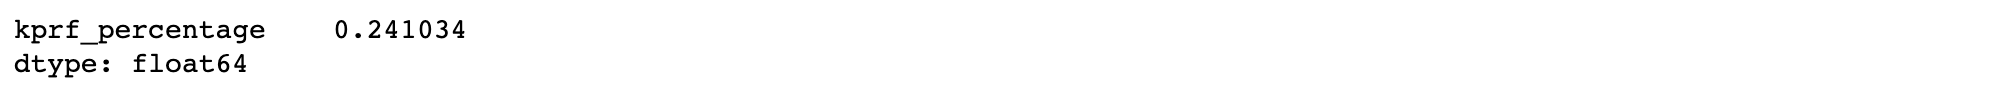

In [ ]:
result_without_admins = uiks.loc[(uiks['count_kprf_admins'] == True),['kprf_percentage']].mean()
result_without_admins

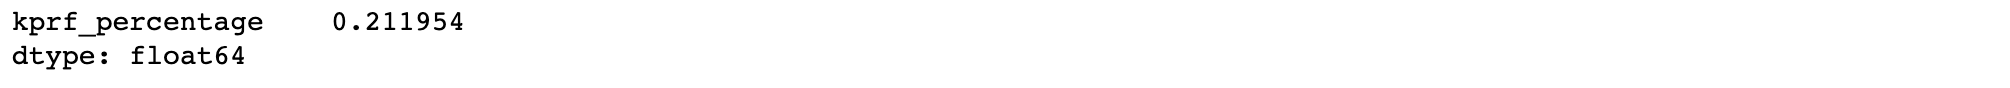

In [ ]:
result_with_admins - result_without_admins

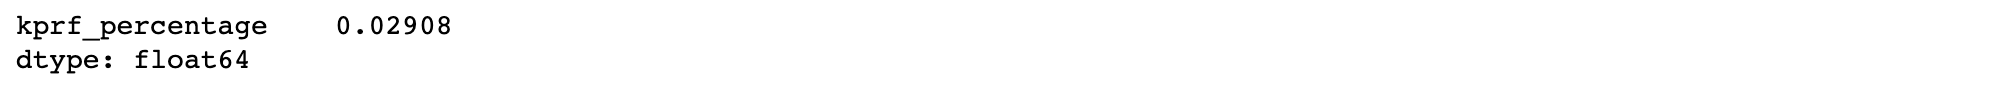

### Задание 2. Бизнес-процессы

Вы хотите поужинать. В холодильнике есть пачка пельменей - вы решаете их приготовить.  Опишите бизнес-процесс, который приведет вас к нужному результату.

### Решение:

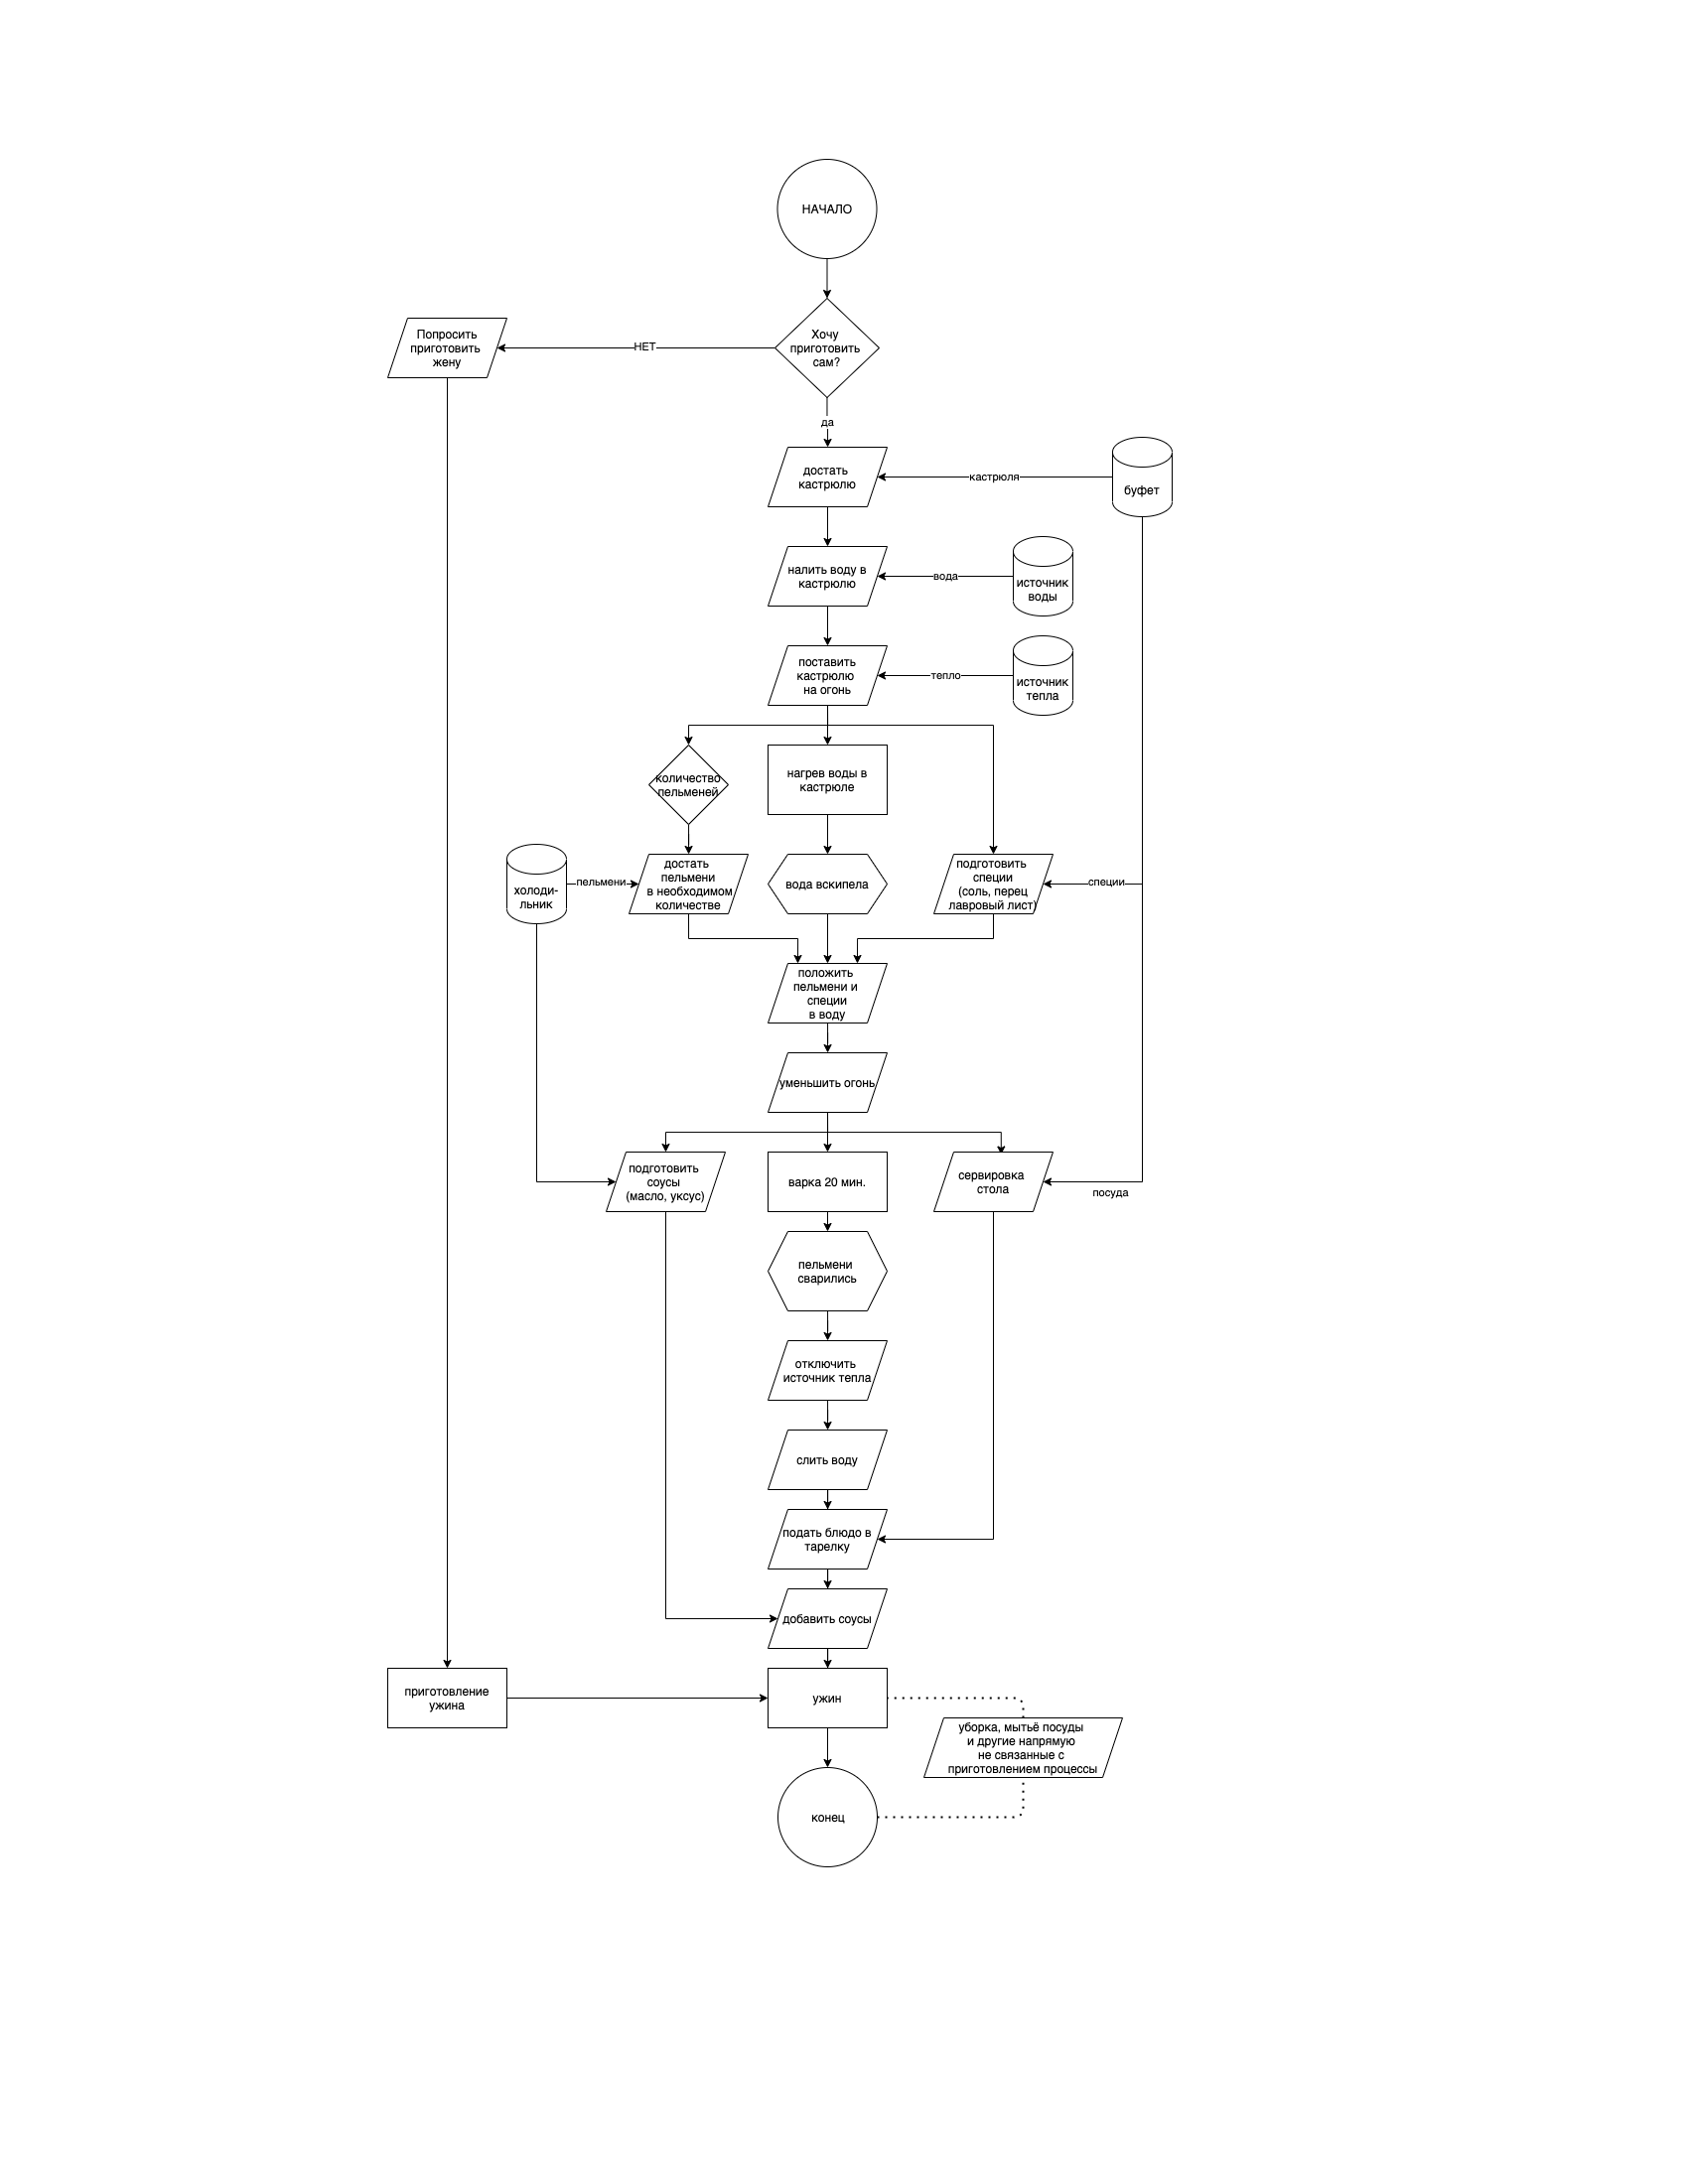

### Задание 3. Дашборды.

Есть сеть пельменных, в которой люди заказывают пельмени через приложение с доставкой на дом.
В этой компании есть коммерческий директор и операционный директор.

Предложите два дашборда, позволяющие им понять все ли идет хорошо в короткой перспективе и поясните причину выбора тех или иных показателей для каждой роли. 


### Решение:

1. Дашборд для коммерческого директора.

В общем случае цель коммерческого директора (КД) - коммерческий успех компании. Обычно успех деятельности КД оценивается показателями, привязанными к валовой выручке  и маржинальности деятельности компании за отчетный период. 

Из задания можно сделать вывод, что основной канал продвижения услуг и взаимодействия с целевой аудиторией - интернет. 
В этом случае, помимо выручки и маржи, важнейшими метриками являются:
- соотношение выручки, полученной от новых клиентов и от повторных заказов
- освоение рекламного бюджета, в т.ч. по видам коммуникации
- конверсия (здесь: отношение полученной выручки к затратам на вид коммуникации)

Эти показатели позволят оперативно отрегулировать систему маркетинга предприятия.

Эскиз дашборда:

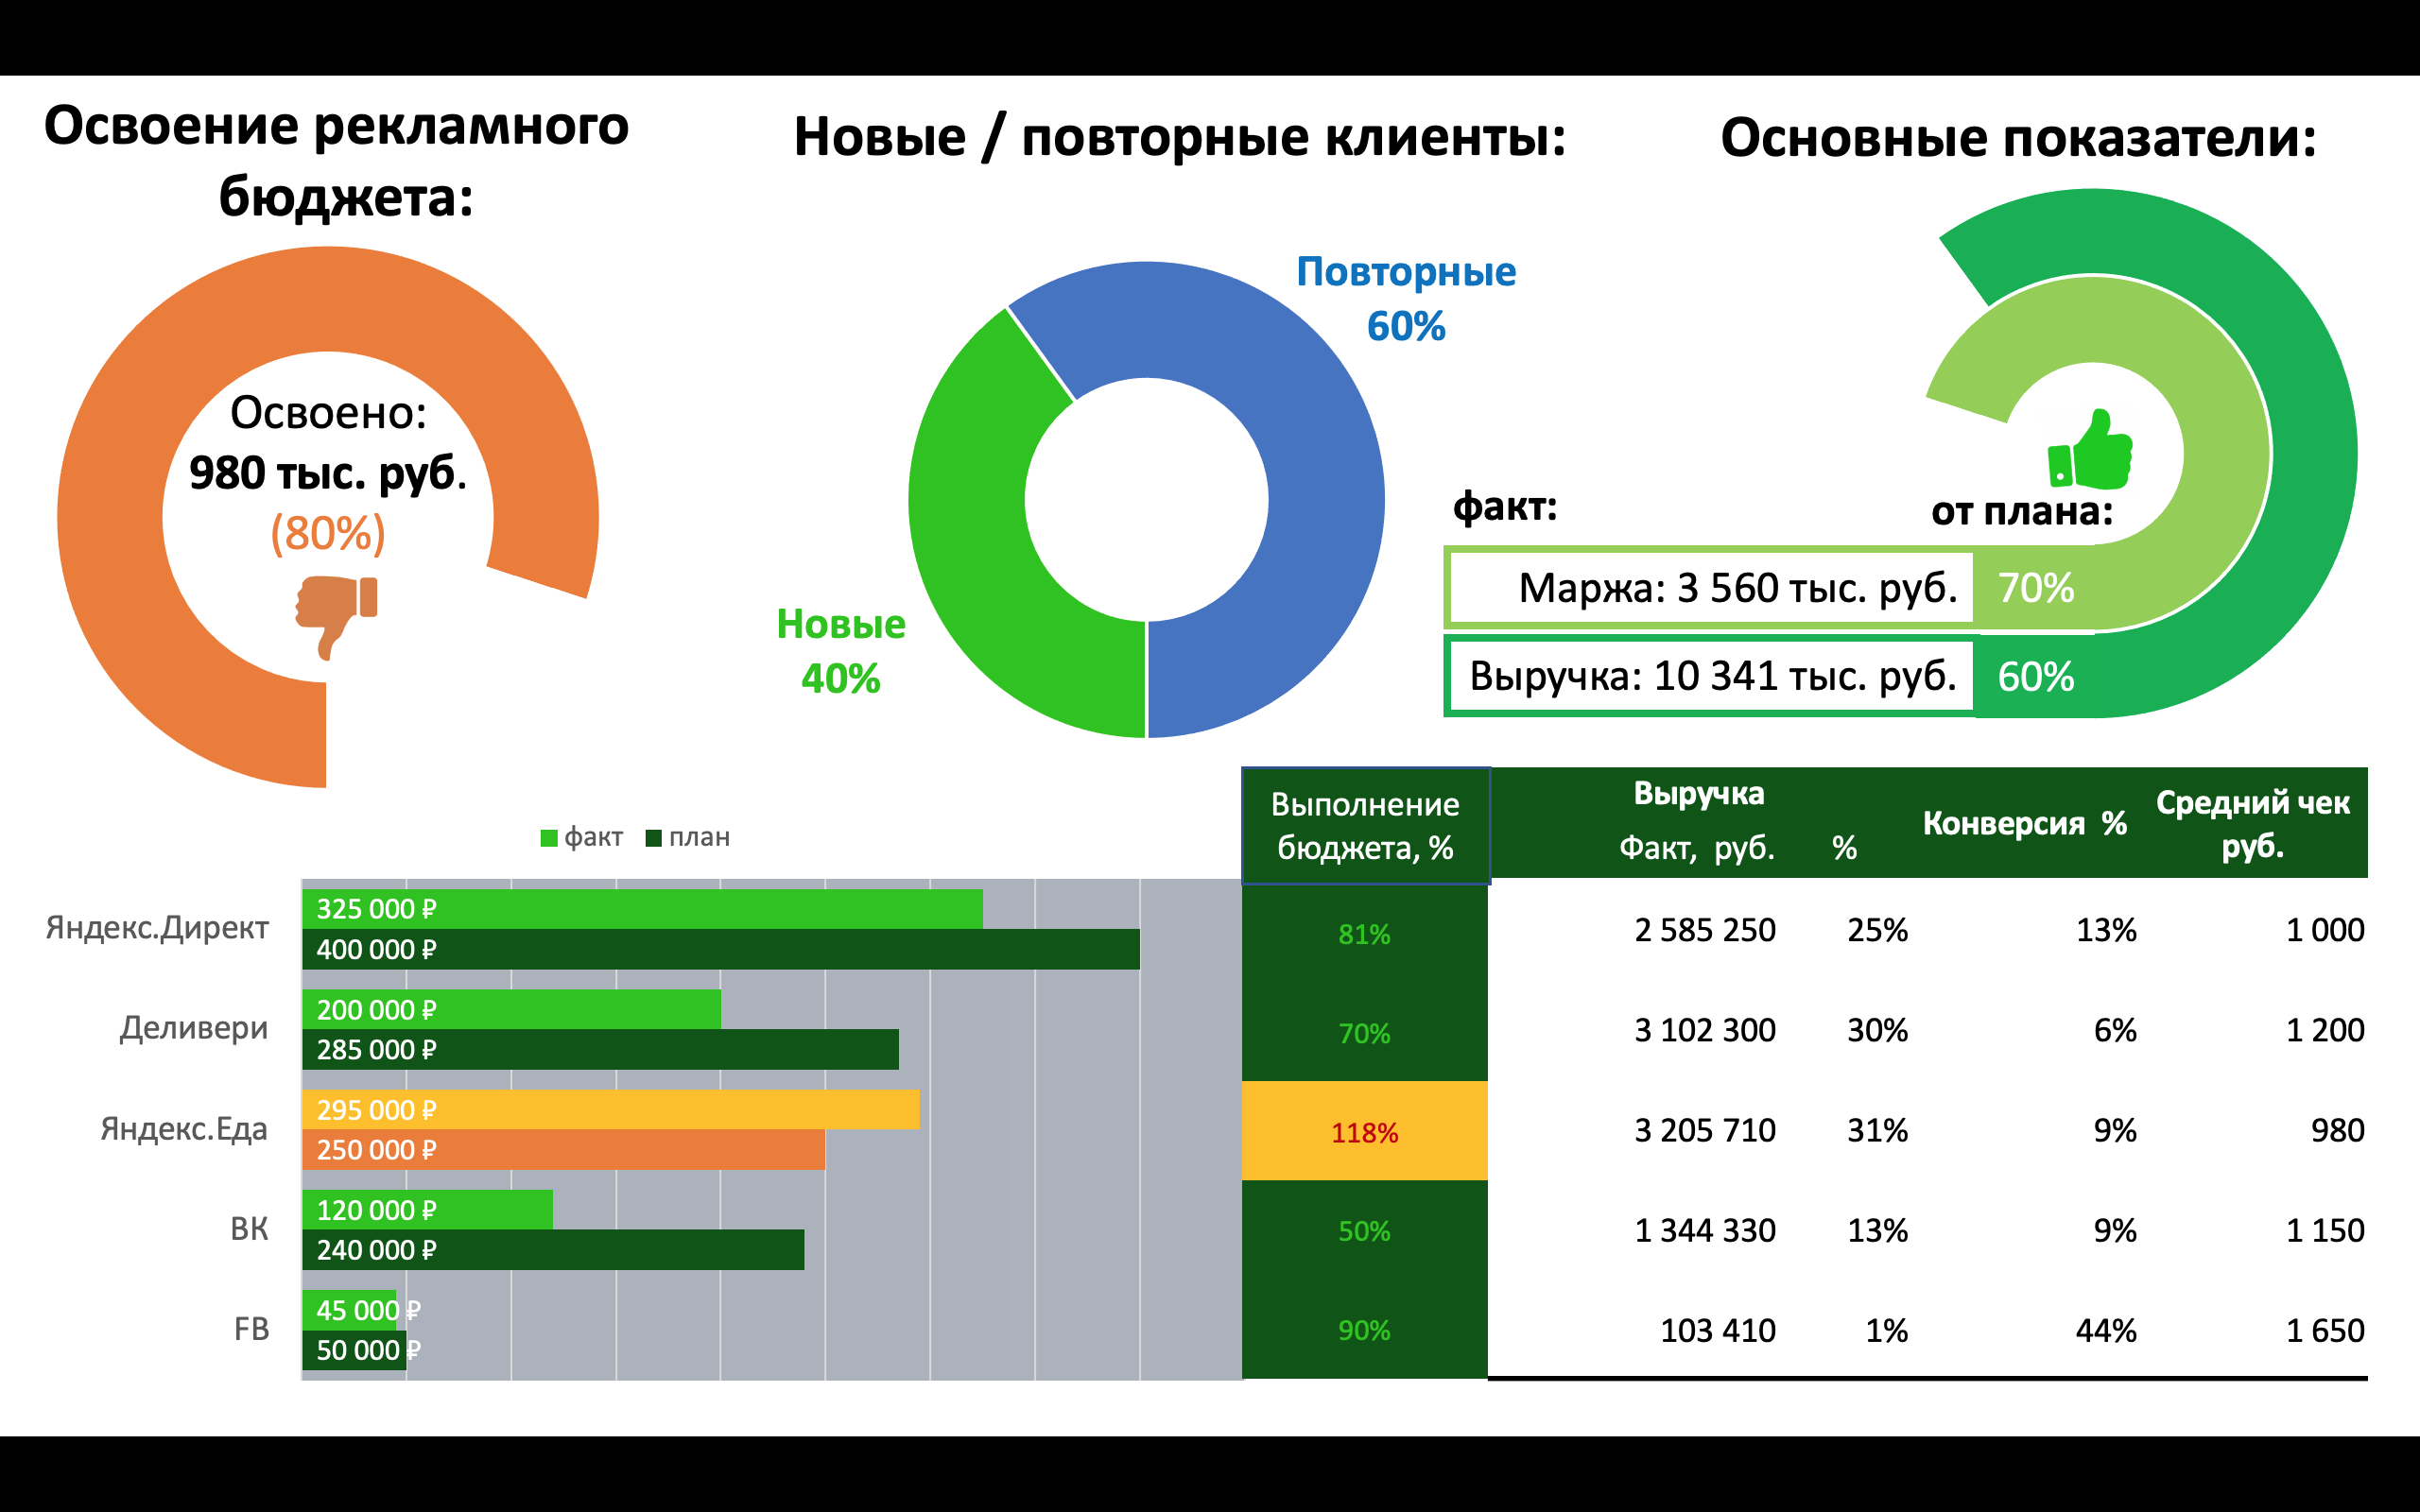

Дашборд можно дополнить "флажками" с указанием тренда. "Флажки" будут показывать рост или снижение показателей по сравнению с предыдущим периодом. В втором уровне дашборда предлагаю возвращять график каждого из показателей за период (сутки, неделя, месяц, год) 

2. Дашборд операционного директора

Предполагаю, что целью операционного директора (ОД) является осуществление бесперебойного функционирования предприятия. При этом задачами ОД являются:
- декомпозиция и организация реализации бизнеспланов и стратегии предприятия
- делегирование и контроль за исполнением задач в рамках планов и задач
- своевременное обеспечение товарооборота (закупка, отгрузка)
- оптимизация бизнес-процессов предприятия
- организация своевременного соблюдения законов и подзаконных актов, наличия разрешений и лицензий, необходимых для осуществления деятельности

Опциональные функции, такие как соблюдение финансовой дисциплины (исполнение платежей, контроль за дебиторской и кредиторской задолженностью и т.д.), оптимальная эксплуатация устройств и механизмов и другие смежные задачи, в рамках примера не рассматриваю.

Дашборд такого ОД я вижу ERP-образным. 
Основные показатели дашборда ОД:
1. Общий блок:
- выручка за период
- маржа (вал.)  за период
2. Загрузка производства:
- количество заказов выполнено, в ожидании, в работе, в доставке (общие и по регионам)
- нагрузка на персонал (заказов в ожидании и в работе на работника кухни, заказов в доставке на курьера)
- среднее время выполнения заказа по каждому этапу (общие и по регионам)
3. Складской блок:
- стоимость складских запасов и их оборачиваемость (в днях, часах) (общая и по регионам)
- стоимость списанных продуктов и блюд (общая и по регионам)
4. Сервисный блок:
- количество  и упущенная выручка из-за отказов клиентов
5. Декоративный блок:
- повар дня
- курьер дня
- случайный отзыв и оценка
6. Календарный блок:
- Количество задач в ожидании, выполнено, не выполнено
- Дней до... (проверки)

Эти показатели позволят отслеживать корректное прохождение бизнес-процессов предприятия, оперативно отладить работу предприятия при возникновении "узких мест": перераспределить заказы, отследить и устранить непредвиденные расходы на производственные/непроизводственные потери и т.д.